# Commodity price forecasting using Random Forest

In [39]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

# tree plotting helper
import graphviz

# model saving
import pickle

In [40]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [41]:
DATADIR = 'data/'
MODELDIR = '../checkpoints/commodity/rf/'

path = os.path.join(DATADIR, 'gold-silver.csv')
data = pd.read_csv(path, header=0, index_col=[0], infer_datetime_format=True, sep=';')

data.head()

,gold,silver
Date,,
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32


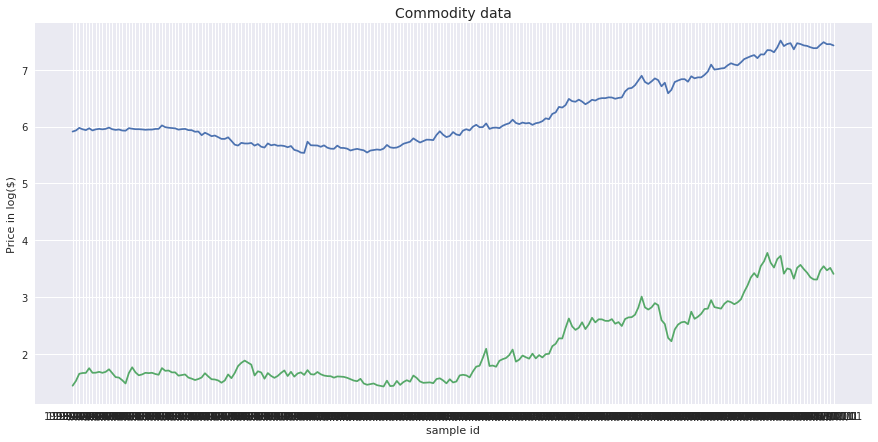

In [42]:
plt.plot(np.log(data.gold), label='log(gold)')
plt.plot(np.log(data.silver), label='log(silver)')
plt.title('Commodity data', fontsize='14')
plt.ylabel('Price in log($)')
plt.xlabel('sample id')
plt.show()

## 2. Data preparation

In [43]:
# function to prepare x and y variable
# for the univariate series
def prepare_data(df, steps=1):
    temp = df.shift(-steps).copy()
    y = temp[:-steps].copy()
    X = df[:-steps].copy()
    return X, y

In [44]:
gold_X, gold_y = prepare_data(np.log(data[['gold']]), steps=1)
silver_X, silver_y = prepare_data(np.log(data[['silver']]), steps=1)

len(gold_X), len(gold_y), len(silver_X), len(silver_y)

(230, 230, 230, 230)

In [45]:
X = pd.concat([gold_X, silver_X], axis=1)
y = pd.concat([gold_y, silver_y], axis=1)

In [46]:
X.head()

,gold,silver
Date,,
1993/11/01,5.911474,1.446919
1993/12/01,5.930387,1.530395
1994/01/01,5.976351,1.656321
1994/02/01,5.951944,1.669592
1994/03/01,5.936876,1.671473


In [47]:
y.head()

,gold,silver
Date,,
1993/11/01,5.930387,1.530395
1993/12/01,5.976351,1.656321
1994/01/01,5.951944,1.669592
1994/02/01,5.936876,1.671473
1994/03/01,5.968708,1.754404


In [48]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=seed, shuffle=False)

print('Training and test data shape:')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training and test data shape:


((218, 2), (218, 2), (12, 2), (12, 2))

## 3. Model evalutation

In [49]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv, y_test_inv = np.exp(y_train), np.exp(y_test)
    y_train_pred_inv, y_test_pred_inv = np.exp(y_train_pred), np.exp(y_test_pred)
    
    # MAE and NRMSE calculation for gold
    y_train_gold = y_train_inv.values[:, 0]
    y_train_pred_gold = y_train_pred_inv[:, 0]  
    y_test_gold = y_test_inv.values[:, 0]
    y_test_pred_gold = y_test_pred_inv[:, 0]
    
    train_rmse_g = np.sqrt(mean_squared_error(y_train_gold, y_train_pred_gold))
    train_mae_g = np.round(mean_absolute_error(y_train_gold, y_train_pred_gold), 3)
    train_nrmse_g = np.round(train_rmse_g/np.std(y_train_gold), 3)

    test_rmse_g = np.sqrt(mean_squared_error(y_test_gold, y_test_pred_gold))
    test_mae_g = np.round(mean_absolute_error(y_test_gold, y_test_pred_gold), 3)
    test_nrmse_g = np.round(test_rmse_g/np.std(y_test_gold), 3)
    
    print('Training and test result for gold:')
    print(f'Training MAE: {train_mae_g}')
    print(f'Trainig NRMSE: {train_nrmse_g}')
    print(f'Test MAE: {test_mae_g}')
    print(f'Test NRMSE: {test_nrmse_g}')
    print()
    
    
    # MAE and NRMSE calculation for silver
    y_train_silver = y_train_inv.values[:, 1]
    y_train_pred_silver = y_train_pred_inv[:, 1]
    y_test_silver = y_test_inv.values[:, 1]
    y_test_pred_silver = y_test_pred_inv[:, 1] 
    
    train_rmse_s = np.sqrt(mean_squared_error(y_train_silver, y_train_pred_silver))
    train_mae_s = np.round(mean_absolute_error(y_train_silver, y_train_pred_silver), 3)
    train_nrmse_s = np.round(train_rmse_s/np.std(y_train_silver), 3)

    test_rmse_s = np.sqrt(mean_squared_error(y_test_silver, y_test_pred_silver))
    test_mae_s = np.round(mean_absolute_error(y_test_silver, y_test_pred_silver), 3)
    test_nrmse_s = np.round(test_rmse_s/np.std(y_test_silver), 3)

    print('Training and test result for silver:')
    print(f'Training MAE: {train_mae_s}')
    print(f'Trainig NRMSE: {train_nrmse_s}')
    print(f'Test MAE: {test_mae_s}')
    print(f'Test NRMSE: {test_nrmse_s}')
    
    return y_train_pred_inv, y_test_pred_inv

## 4. Model building and training

In [50]:
seed = 42

### Model - 1 (Final Model)

Training and test result for gold:
Training MAE: 14.067
Trainig NRMSE: 0.07
Test MAE: 53.061
Test NRMSE: 1.39

Training and test result for silver:
Training MAE: 0.497
Trainig NRMSE: 0.125
Test MAE: 2.684
Test NRMSE: 1.198


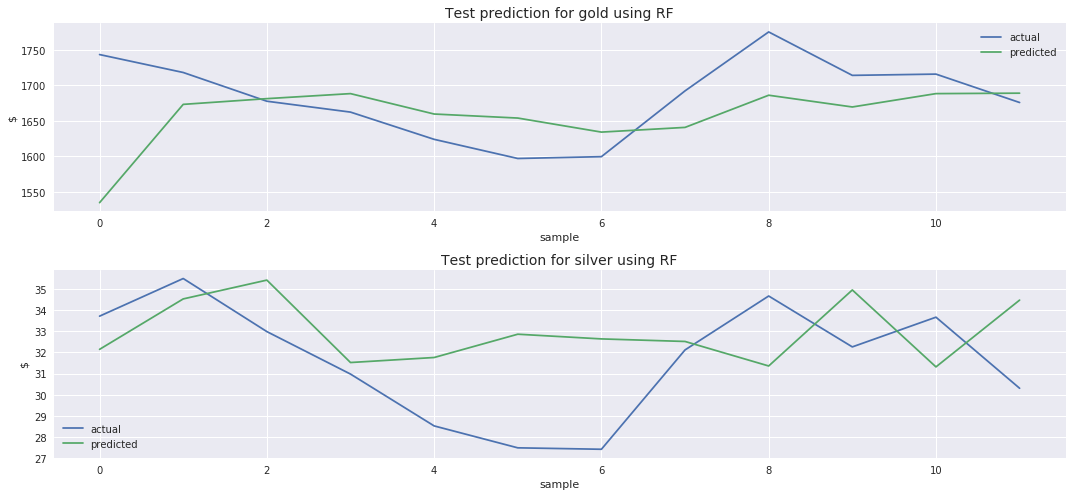

In [51]:
params = {'n_estimators': 200,
          'min_samples_split' : 5,
           'min_samples_leaf' : 2,
          'random_state' : seed
         }

model = RegressorChain(RandomForestRegressor(**params))
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'rf-v1.model'), 'wb'))


# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

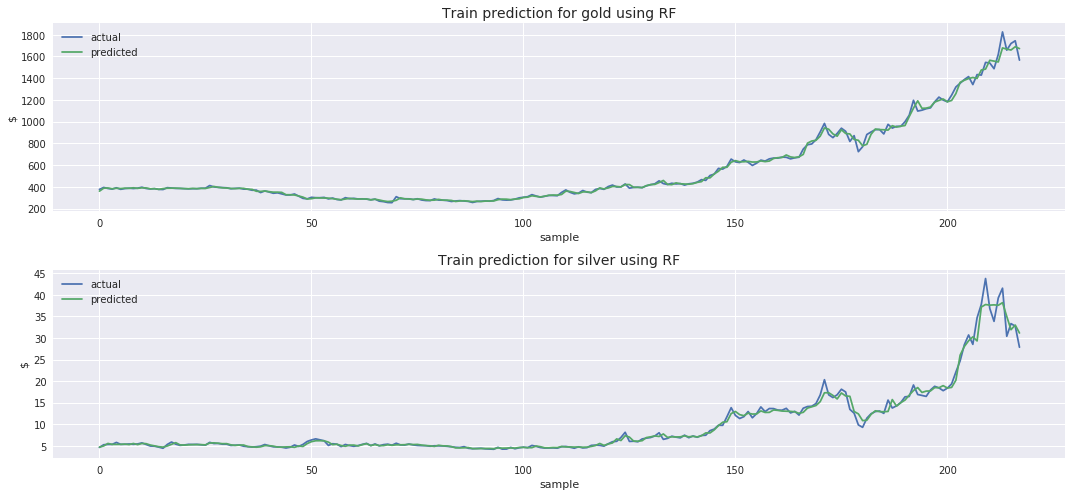

In [52]:
plt.subplot(211)
plt.plot(np.exp(y_train.values[:, 0]), label='actual')
plt.plot(y_train_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Train prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_train.values[:, 1]), label='actual')
plt.plot(y_train_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Train prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Model - 2

Training and test result for gold:
Training MAE: 15.674
Trainig NRMSE: 0.077
Test MAE: 56.62
Test NRMSE: 1.44

Training and test result for silver:
Training MAE: 0.555
Trainig NRMSE: 0.137
Test MAE: 2.529
Test NRMSE: 1.113


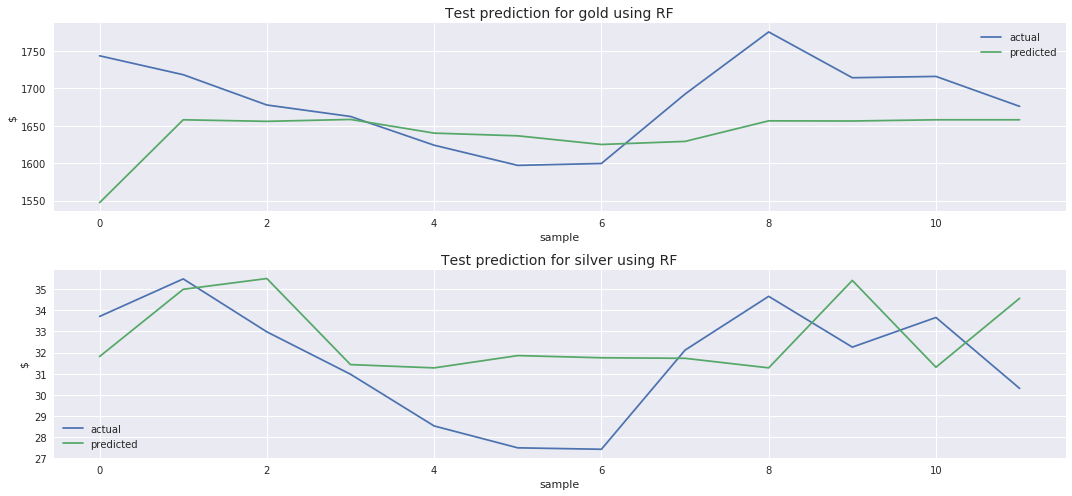

In [53]:
params = {'n_estimators': 300,
          'min_samples_split' : 7,
          'min_samples_leaf' : 3,
          'random_state' : seed
         }

model = RegressorChain(RandomForestRegressor(**params))
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'rf-v2.model'), 'wb'))


# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Model - 3

Training and test result for gold:
Training MAE: 9.588
Trainig NRMSE: 0.046
Test MAE: 64.84
Test NRMSE: 1.55

Training and test result for silver:
Training MAE: 0.371
Trainig NRMSE: 0.095
Test MAE: 2.769
Test NRMSE: 1.266


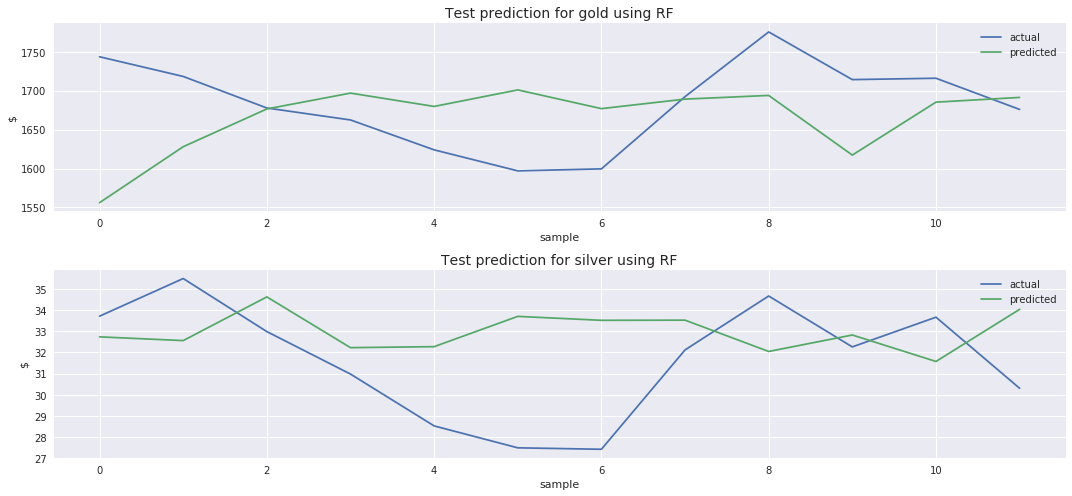

In [54]:
params = {'n_estimators': 300,
          'min_samples_split' : 2,
           'min_samples_leaf' : 1,
          'random_state' : seed
         }

model = RegressorChain(RandomForestRegressor(**params))
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'rf-v3.model'), 'wb'))


# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Model - 4

/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training and test result for gold:
Training MAE: 9.098
Trainig NRMSE: 0.048
Test MAE: 94.642
Test NRMSE: 2.187

Training and test result for silver:
Training MAE: 0.387
Trainig NRMSE: 0.101
Test MAE: 3.109
Test NRMSE: 1.337


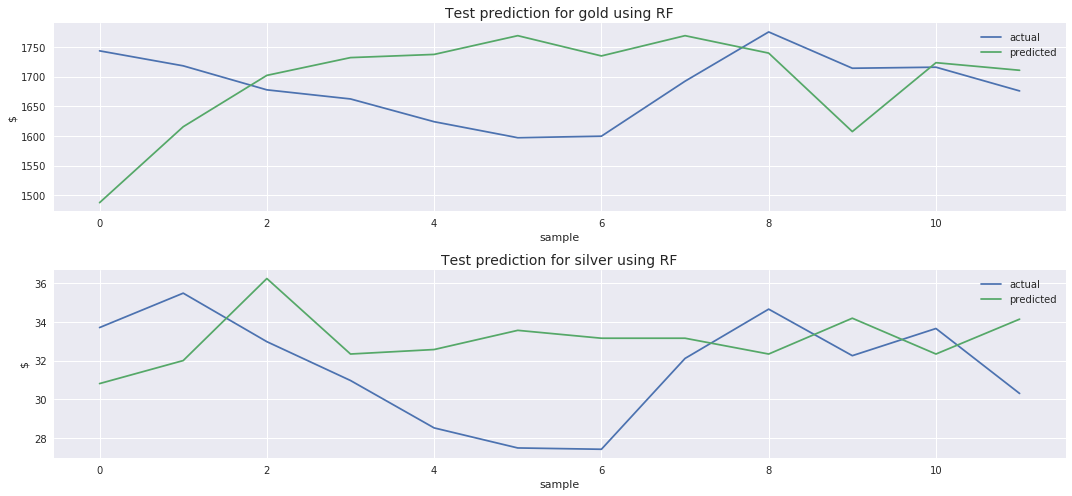

In [55]:
model = RegressorChain(RandomForestRegressor(random_state=seed))
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'rf-v4.model'), 'wb'))


# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Model - 5

/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/manish/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training and test result for gold:
Training MAE: 9.098
Trainig NRMSE: 0.048
Test MAE: 94.642
Test NRMSE: 2.187

Training and test result for silver:
Training MAE: 0.387
Trainig NRMSE: 0.101
Test MAE: 3.109
Test NRMSE: 1.337


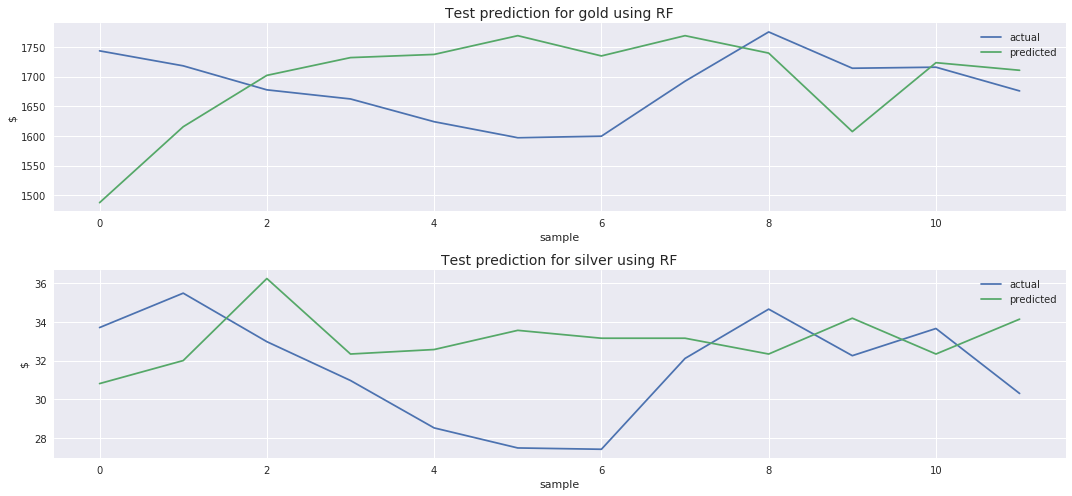

In [56]:
model = RegressorChain(RandomForestRegressor(random_state=seed, warm_start=True))
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'rf-v5.model'), 'wb'))


# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred_inv[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RF', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred_inv[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RF', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()